In [1]:
# Library import
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter
import string
from nltk.corpus import stopwords
import warnings
from nltk.tokenize import word_tokenize
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go

plt.style.use('ggplot')

In [2]:
comments = pd.read_csv('Data/attack_annotated_comments.tsv', sep='\t', index_col=0)
annotations = pd.read_csv('Data/attack_annotations.tsv', sep='\t')

In [3]:
# Labels are decided through majority vote (One-hot)
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5
comments['attack'] = labels
# Attack will be changed to: 1 if a comment consist a personal attack and 0 otherwise
comments['attack'] = comments['attack'].astype('int')

In [4]:
comments.describe()

year         attack
count  115864.000000  115864.000000
mean     2009.224306       0.117293
std         2.900431       0.321770
min      2001.000000       0.000000
25%      2007.000000       0.000000
50%      2009.000000       0.000000
75%      2011.000000       0.000000
max      2016.000000       1.000000

In [5]:
df_test = comments.loc[(comments['split'] == 'dev')]
df_test = df_test.drop(columns=['year', 'logged_in', 'ns', 'sample', 'split'])
df_test.to_csv('Data/test.csv', index=False)

In [6]:
comments['attack'].value_counts()

0    102274
1     13590
Name: attack, dtype: int64

In [7]:
# The entire dataset into one string
train_string = " ".join(comments['comment'].values)
print(f"***** Extract of train_string ***** \n{train_string[:10]}", "\n")
# Split with white space
splits = train_string.split()  
print(f"***** Extract of splits ***** \n{splits[:10]}\n")

***** Extract of train_string ***** 
`-NEWLINE_ 

***** Extract of splits ***** 
['`-NEWLINE_TOKENThis', 'is', 'not', '``creative``.', 'Those', 'are', 'the', 'dictionary', 'definitions', 'of']



In [8]:
print(f"Number of strings: {len(splits)}")
print(f"Number of unique strings: {len(set(splits))}")

Number of strings: 7974412
Number of unique strings: 504559


In [9]:
from nltk import word_tokenize, sent_tokenize, FreqDist
freq_splits = FreqDist(splits)
print(f"***** 10 most common strings ***** \n{freq_splits.most_common(10)}", "\n")

***** 10 most common strings ***** 
[('the', 321456), ('to', 208479), ('of', 164114), ('and', 157782), ('a', 152497), ('is', 125699), ('I', 123743), ('you', 112269), ('that', 103577), ('in', 96988)] 



In [10]:
short = set(s for s in splits if len(s)<4)
short = [(s, freq_splits[s]) for s in short]
short.sort(key=lambda x:x[1], reverse=True)
short[:10]

[('the', 321456),
 ('to', 208479),
 ('of', 164114),
 ('and', 157782),
 ('a', 152497),
 ('is', 125699),
 ('I', 123743),
 ('you', 112269),
 ('in', 96988),
 ('for', 66666)]

In [11]:
long = set(s for s in splits if len(s)>15)
long = [(s, freq_splits[s]) for s in long]
long.sort(key=lambda x:x[1], reverse=True)
long[:10]

[('NEWLINE_TOKENNEWLINE_TOKEN==', 18944),
 ('`NEWLINE_TOKENNEWLINE_TOKEN==', 7216),
 ('NEWLINE_TOKENNEWLINE_TOKEN', 5098),
 ('==NEWLINE_TOKENNEWLINE_TOKENI', 3021),
 ('NEWLINE_TOKENNEWLINE_TOKEN`', 2183),
 ('NEWLINE_TOKENNEWLINE_TOKENI', 2113),
 ('==NEWLINE_TOKENNEWLINE_TOKENThe', 928),
 ('NEWLINE_TOKENNEWLINE_TOKENThe', 757),
 ('==NEWLINE_TOKENNEWLINE_TOKENYou', 747),
 ('NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKEN==', 705)]

In [12]:
def summarise(pattern, strings, freq):
    """Summarise strings matching a pattern."""
    # Find matches
    compiled_pattern = re.compile(pattern)
    matches = [s for s in strings if compiled_pattern.search(s)]
    
    # Print volume and proportion of matches
    print("{} strings, that is {:.6%} of total".format(len(matches), len(matches)/ len(strings)))
    
    # Create list of tuples containing matches and their frequency
    output = [(s, freq[s]) for s in set(matches)]
    output.sort(key=lambda x:x[1], reverse=True)
    
    return output[:10]
# Find strings possibly containing html tag
summarise(r"\d", splits, freq_splits)

102433 strings, that is 1.284521% of total


[('2', 1819),
 ('3', 1493),
 ('1', 1170),
 ('4', 1024),
 ('5', 919),
 ('2006', 788),
 ('10', 767),
 ('9000', 753),
 ('1px', 695),
 ('2007', 689)]

In [13]:
summarise(r"\d", splits, freq_splits) # numbers

102433 strings, that is 1.284521% of total


[('2', 1819),
 ('3', 1493),
 ('1', 1170),
 ('4', 1024),
 ('5', 919),
 ('2006', 788),
 ('10', 767),
 ('9000', 753),
 ('1px', 695),
 ('2007', 689)]

In [14]:
summarise(r"\w+-+\w+", splits, freq_splits) # hyphenated

49362 strings, that is 0.619005% of total


[("Pro-Assad.Hanibal911You're", 661),
 ('admin-NEWLINE_TOKENBad', 575),
 ('style=``vertical-align:top;', 392),
 ('style=``background-color:', 357),
 ('non-free', 345),
 ('x-large;', 342),
 ('vertical-align:top``|NEWLINE_TOKEN{|', 299),
 ('background-color:#F5FFFA;', 285),
 ('so-called', 281),
 ('Fan-1967', 241)]

In [15]:
summarise(r"\w+[_!&/)(<\|}{\[\]]\w+", splits, freq_splits) # combination

281546 strings, that is 3.530618% of total


[('NEWLINE_TOKENNEWLINE_TOKEN==', 18944),
 ('`NEWLINE_TOKENNEWLINE_TOKEN==', 7216),
 ('NEWLINE_TOKENNEWLINE_TOKEN', 5098),
 ('==NEWLINE_TOKENNEWLINE_TOKENI', 3021),
 ('NEWLINE_TOKEN', 2579),
 ('NEWLINE_TOKENNEWLINE_TOKEN`', 2183),
 ('NEWLINE_TOKENNEWLINE_TOKENI', 2113),
 ('==NEWLINE_TOKENNEWLINE_TOKENThe', 928),
 ('NEWLINE_TOKEN*', 814),
 ('NEWLINE_TOKENNEWLINE_TOKENThe', 757)]

In [16]:
summarise(r"/(.*)\1*/\1/", splits, freq_splits) # duplicates

308 strings, that is 0.003862% of total


[('penis/////Small', 249),
 ('///WP:CHICAGO/WP:FOUR)', 12),
 ('///(e-mail)', 4),
 ('///', 3),
 ('—////', 3),
 ('(0/0/0/0)', 2),
 ('http://www.ekantipur.com/the-kathmandu-post/2010/01/01/top-stories/Parties-vow-to-end-trust-deficit/3609/NEWLINE_TOKEN-',
  2),
 ('NEWLINE_TOKENNEWLINE_TOKENhttp://en.wikipedia.org/wiki/The_Real_Stephen_Hawkinghttp://en.wikipedia.org/wiki/The_Real_Stephen_Hawkinghttp://en.wikipedia.org/wiki/The_Real_Stephen_Hawkinghttp://en.wikipedia.org/wiki/The_Real_Stephen_Hawkinghttp://en.wikipedia.org/wiki/The_Real_Stephen_Hawkinghttp://en.wikipedia.org/wiki/The_Real_Stephen_Hawkinghttp://en.wikipedia.org/wiki/The_Real_Stephen_Hawkinghttp://en.wikipedia.org/wiki/The_Real_Stephen_Hawkinghttp://en.wikipedia.org/wiki/The_Real_Stephen_Hawkinghttp://en.wikipedia.org/wiki/The_Real_Stephen_Hawkinghttp://en.wikipedia.org/wiki/The_Real_Stephen_Hawkinghttp://en.wikipedia.org/wiki/The_Real_Stephen_Hawkinghttp://en.wikipedia.org/wiki/The_Real_Stephen_Hawkinghttp://en.wikipedia.org

In [17]:
def find_outlaw(word):
    """Find words that contain a same character 3+ times in a row."""
    is_outlaw = False
    for i, letter in enumerate(word):
        if i > 1:
            if word[i] == word[i-1] == word[i-2] and word[i].isalpha():
                is_outlaw = True
                break
    return is_outlaw
outlaws = [s for s in splits if find_outlaw(s)]
print("{} strings, that is {:.2%} of total".format(len(outlaws), len(outlaws)/ len(splits)))
outlaw_freq = [(s, freq_splits[s]) for s in set(outlaws)]
outlaw_freq.sort(key=lambda x:x[1], reverse=True)
outlaw_freq[:10]

8350 strings, that is 0.10% of total


[('OFFFUCK', 360),
 ('Annnete<>Pink', 322),
 ('background-color:#F5FFFA;', 285),
 ('UUUUUU', 193),
 ('CCCCCC', 192),
 ('KKKKKK', 192),
 ('FFFFF', 192),
 ('background-color:#F5FFFA``NEWLINE_TOKEN!', 152),
 ('LOLOOOLBOOTSTOOTS', 134),
 ('YAAAA!@!!!!!!AH', 128)]

In [18]:
comments['dup'] = comments.duplicated(subset=None, keep='first')
comments['dup'].value_counts()
comments = comments[comments['dup'] == False]
del comments['dup']  # deleting "dup" column

In [19]:
comments['tokenised_comment'] = comments['comment'].apply(lambda x: word_tokenize(x))

In [20]:
stop_words = stopwords.words('english')

In [21]:
tokens = comments['tokenised_comment'].values
tokens = tokens.tolist()
tokens = [item for sublist in tokens for item in sublist]
freq_stopwords = [(sw, tokens.count(sw)) for sw in stop_words]
freq_stopwords.sort(key=lambda x: x[1], reverse=True)
freq_stopwords[:10]

[('the', 323407),
 ('to', 210150),
 ('of', 164915),
 ('and', 160702),
 ('a', 153624),
 ('is', 132272),
 ('you', 130686),
 ('that', 111911),
 ('in', 99079),
 ('it', 88810)]

In [22]:
n_stopwords = len([t for t in tokens if t in stop_words])
print(f"{n_stopwords} tokens are stop words.")
print(f"That is {round(100*n_stopwords/len(tokens),2)}%.")

3303675 tokens are stop words.
That is 34.16%.


In [23]:
# data cleaning
stop_words.remove('not')
stop_words.remove('no')
comments['comment'] = comments['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))  # removing stopwords
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))  # remove NEWLINE_TOKEN
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))  # remove TAB_TOKEN
comments["comment"] = comments['comment'].str.replace(r'[^\w\s]+', '') # remove punctuation
comments["comment"] = comments['comment'].str.replace(r'\d+', '') # Remove numbers

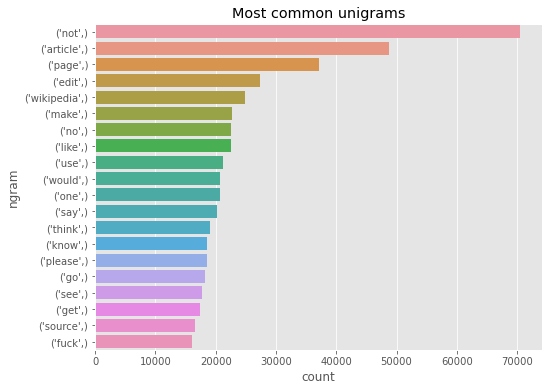

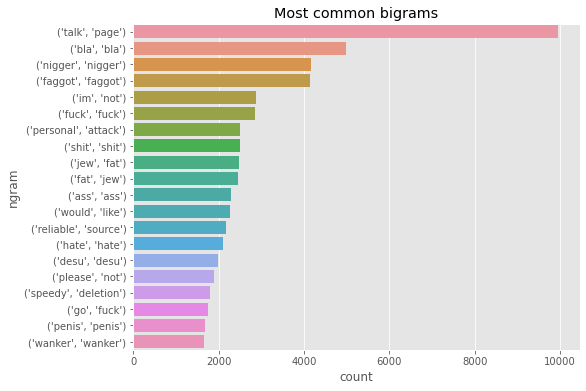

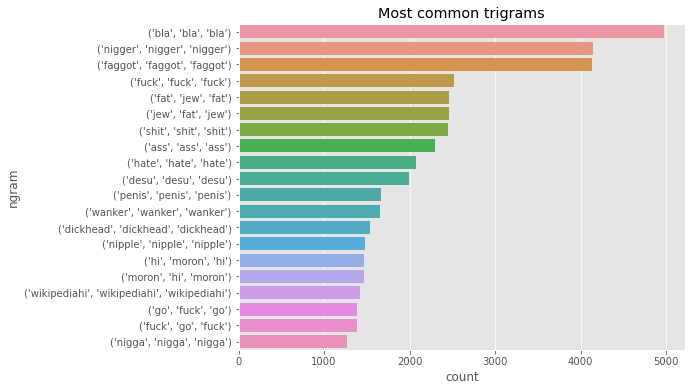

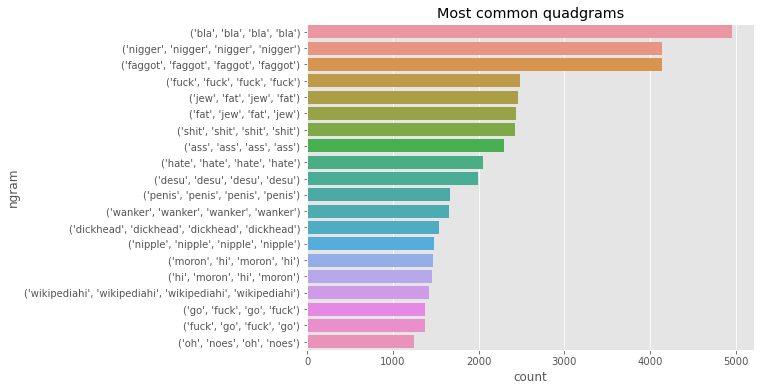

In [24]:
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

def preprocess_text(text):
    """Preprocess text into normalised tokens."""
    # Tokenise words into alphabetic tokens
    tokeniser = RegexpTokenizer(r'[A-Za-z]{2,}')
    tokens = tokeniser.tokenize(text)
    
    # Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
    
    # Remove stopwords
    keywords= [lemma for lemma in lemmas if lemma not in stop_words]
    return keywords
def get_frequent_ngram(corpus, ngram, n=20):
    """Find most common n n-grams tokens."""
    # Preprocess each document
    documents = [preprocess_text(document) for document in corpus]
    
    # Find ngrams per document
    n_grams = [list(ngrams(document, ngram)) for document in documents]
    
    # Find frequency of ngrams
    n_grams_flattened = [item for sublist in n_grams for item in sublist]
    freq_dist = FreqDist(n_grams_flattened)
    top_freq = freq_dist.most_common(n)
    return pd.DataFrame(top_freq, columns=["ngram", "count"])
# Get frequent ngrams for all 4
for i in range(1,5):
    mapping = {1:"uni", 2:"bi", 3:"tri", 4:"quad"}
    plt.figure(figsize=(8,6))
    sns.barplot(x="count", y="ngram", data=get_frequent_ngram(comments['comment'], i))
    plt.title(f"Most common {mapping[i]}grams")
    plt.savefig("Figures/common{}grams.png".format(i), bbox_inches='tight')

In [25]:
comments['comment_len'] = comments['comment'].apply(lambda x: len(x.split()))
np.mean(comments['comment_len'])

41.231788822879246

In [26]:
# count number of occurences of each word
counts = Counter()
for index, row in comments.iterrows():
    counts.update(row['tokenised_comment'])

In [27]:
df_train = comments.loc[(comments['split'] == 'train')]
df_valid = comments.loc[(comments['split'] == 'valid')]

In [28]:
df_train = df_train.drop(columns=['year', 'logged_in', 'ns', 'sample', 'split'])
df_valid = df_valid.drop(columns=['year', 'logged_in', 'ns', 'sample', 'split'])

In [29]:
# Create seperate .csv files for each partition

#df_train.to_csv('Data/train.csv', index=False)
#df_test.to_csv('Data/test.csv', index=False)

In [30]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

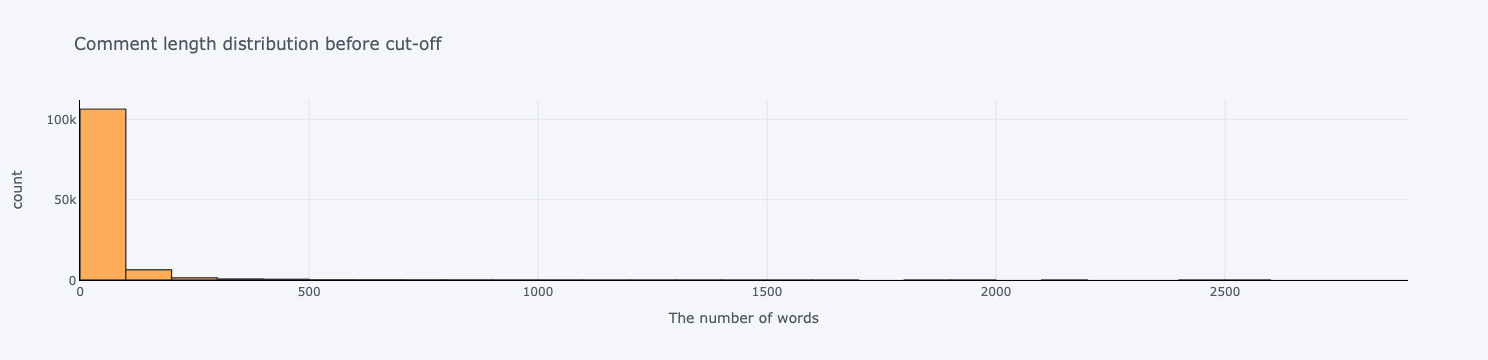

In [31]:
# length of comments before cut-off
comments['comment_length'] = comments['comment'].apply(lambda x: len(x.split()))
comments['comment_length'].iplot(
    kind='hist',
    bins=50,
    xTitle='The number of words',
    linecolor='black',
    yTitle='count',
    title='Comment length distribution before cut-off')

In [32]:
# Max number of words in each comment; the mean of all comments is app. 69, 
MAX_SEQUENCE_LENGTH = 100
def comment_cut_off(x):
    x = x.split(maxsplit=MAX_SEQUENCE_LENGTH)
    x = ' '.join(x[:MAX_SEQUENCE_LENGTH])
    return x

In [33]:
comments['comment'] = comments['comment'].apply(comment_cut_off)
comments.drop(comments[comments.comment.str.len() < 5].index, inplace=True)

In [34]:
comments['comment'].value_counts

<bound method IndexOpsMixin.value_counts of rev_id
37675        This not creative Those dictionary definitions...
44816        term standard model less NPOV I think wed pref...
49851        True false situation March such A Saudi propos...
89320        Next maybe could work less condescending sugge...
93890                            This page need disambiguation
                                   ...                        
699848324    These sources exactly exude sense impartiality...
699851288    The Institute Historical Review peerreviewed j...
699857133    The way trying describe article serious step w...
699891012    Warning There clearly protectionist regime goi...
699897151    Alternate option Is perhaps enough newsworthy ...
Name: comment, Length: 115716, dtype: object>

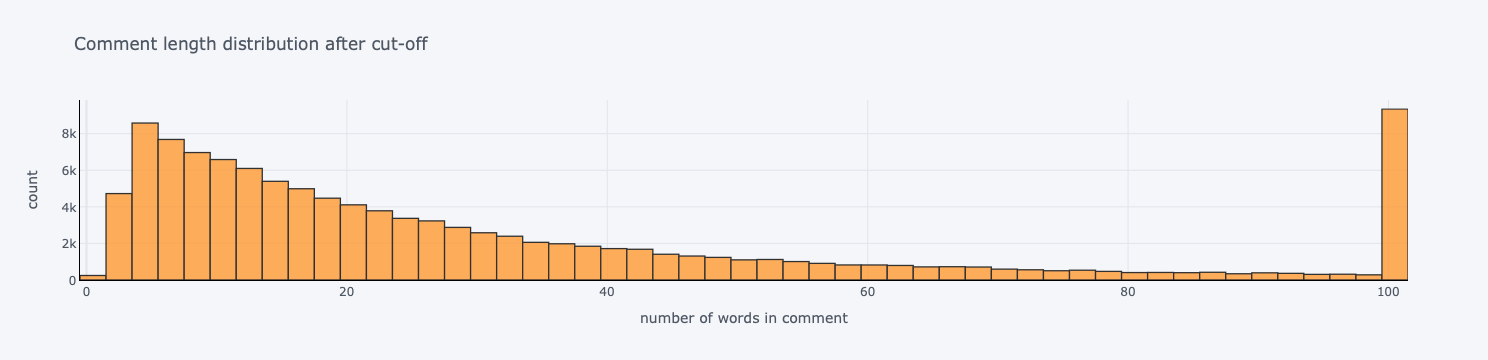

In [35]:
# Length of comments after cut-off
comments['comment_length'] = comments['comment'].apply(lambda x: len(x.split()))
# length of comments after cut-off
comments['comment_length'] = comments['comment'].apply(lambda x: len(x.split()))
comments['comment_length'].iplot(
    kind='hist',
    bins=50,
    xTitle='number of words in comment',
    linecolor='black',
    yTitle='count',
    title='Comment length distribution after cut-off')

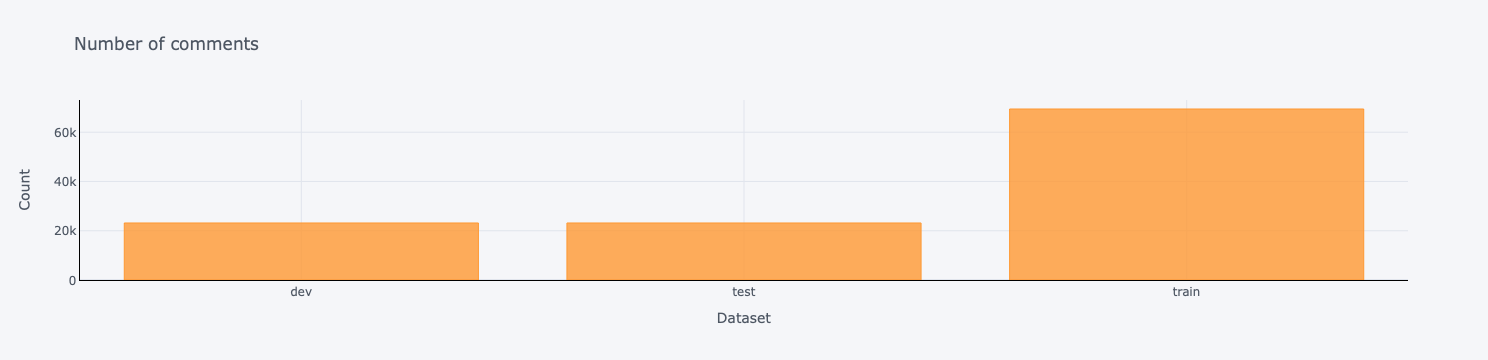

In [36]:
comments.groupby('split').count()['comment'].iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.8,
                                                         title='Number of comments', xTitle='Dataset')

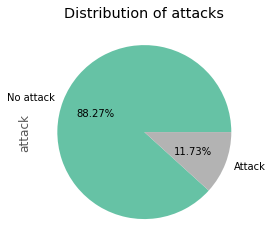

In [37]:
comments['attack'].value_counts().plot(kind='pie',autopct='%.2f%%',labels=['No attack','Attack'],cmap='Set2', title='Distribution of attacks') 
# distribution of Toxic or Non Toxic. 1 detemines Toxic 
plt.show()